# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate new images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from loading in data to defining and training adversarial networks. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the CelebFaces Attributes Dataset ([CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)) to train your adversarial networks.

This dataset is more complex than the number datasets like MNIST or SVHN you've been working with, and so, you should prepare to **define deeper networks and train them for a longer time** to get good results. It is suggested that you utilize a GPU for training.

Some sample data is show below:

<img src='assets/processed_face_data.png' width=60% />

If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip). This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing.

In [1]:
data_dir = 'inputs/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests

%matplotlib inline

## Visualize the CelebA Data

The CelebA dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with **3 color channels (RGB)** each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done some of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to **64x64x3 NumPy images**. This pre-processed dataset is a smaller subset of the very large CelebA data.

There are a few other steps that you'll need to transform this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `inputs/` and data transformation passed in.

In [2]:
import torch
from torchvision import datasets
from torchvision import transforms

In [3]:
def get_dataloader(batch_size, image_size, data_dir='inputs/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The number of images in each batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    transform = transforms.Compose([
        transforms.Resize([image_size, image_size]),
        transforms.ToTensor()
    ])
    
    dataset = datasets.ImageFolder(root=data_dir, transform=transform)
    loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, num_workers=0)

    return loader

## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [4]:
batch_size = 128
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
celeba_train_loader = get_dataloader(batch_size, img_size)

Next, you can view some images! You should seen square images of somewhat-centered faces.

You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image. Suggested `imshow` code is below, but it may not be perfect.

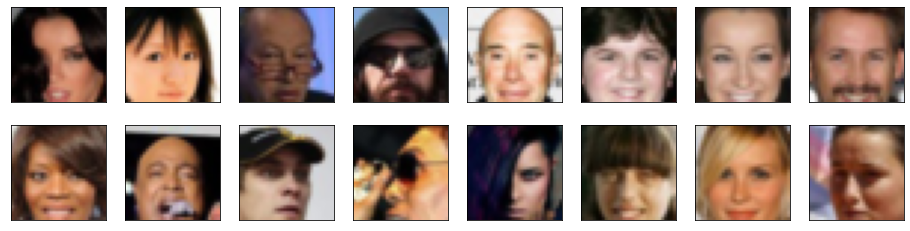

In [39]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    assert npimg.shape == (3, 32, 32)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
data_iter = iter(celeba_train_loader)
images, _ = data_iter.next()

fig = plt.figure(figsize=(16, 4))
plot_size = 16
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size//2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing. The output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. Right now, they are in a range from 0-1.

In [6]:
def scale(x, feature_range=(-1, 1)):
    '''
    Scale takes in an image x and returns that image, scaled
    with a feature_range of pixel values from -1 to 1. 
    This function assumes that the input x is already scaled from 0-1.
    '''
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

img = images[0]
print('Min: ', img.min())
print('Max: ', img.max())
scaled_img = scale(img)
print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(0.0471)
Max:  tensor(0.9647)
Min:  tensor(-0.9059)
Max:  tensor(0.9294)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a **deep network with normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [8]:
import torch.nn as nn
import torch.nn.functional as F

In [9]:
def conv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):
    """
    Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))

    return nn.Sequential(*layers)

In [10]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        self.conv_dim1 = conv_dim
        self.conv_dim2 = conv_dim * 2
        self.conv_dim3 = conv_dim * 4

        # 32x32 in
        self.conv1 = conv(3, self.conv_dim1, batch_norm=False)
        # 16x16 out
        self.conv2 = conv(self.conv_dim1, self.conv_dim2, batch_norm=True)
        # 8x8 out
        self.conv3 = conv(self.conv_dim2, self.conv_dim3, batch_norm=True)
        # 4x4 out

        # fully-connected layer
        self.fc = nn.Linear(self.conv_dim3 * 4 * 4, 1)
        # activation function
        self.leaky = nn.LeakyReLU(0.2)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits as output of the neural network
        """
         # first hidden layer
        x = self.conv1(x)
        x = self.leaky(x)
        # second hidden layer
        x = self.conv2(x)
        x = self.leaky(x)
        # third hidden layer
        x = self.conv3(x)
        x = self.leaky(x)
        # flatten
        x = x.view(-1, self.conv_dim3 * 4 * 4)
        # fully-connected layer
        x = self.fc(x)
        # return logits
        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a new image of the same size as our training data, namely 32x32x3. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape 32x32x3

In [11]:
def deconv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):
    """
    Creates a transposed-convolutional layer, with optional batch normalization.
    """
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)

    layers.append(transpose_conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))

    return nn.Sequential(*layers)

In [12]:
class Generator(nn.Module):
    
    def __init__(self, z_size=100, conv_dim=32):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        self.conv_dim1 = conv_dim * 4
        self.conv_dim2 = conv_dim * 2
        self.conv_dim3 = conv_dim
        
        # fully-connected layer
        self.fc = nn.Linear(z_size, self.conv_dim1 * 4 * 4)
        
        # 4x4 in
        self.tconv1 = deconv(self.conv_dim1, self.conv_dim2, batch_norm=True)
        # 8x8 out
        self.tconv2 = deconv(self.conv_dim2, self.conv_dim3, batch_norm=True)
        # 16x16 out
        self.tconv3 = deconv(self.conv_dim3, 3, batch_norm=False)
        # 32x32 out

        # activation functions
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # fully-connected layer
        x = self.fc(x)
        # reshape
        x = x.view(-1, self.conv_dim1, 4, 4) # (batch-size, depth, width, height), -1 is a placeholder
        # first hidden layer
        x = self.tconv1(x)
        x = self.relu(x)
        # second hidden layer
        x = self.tconv2(x)
        x = self.relu(x)
        # third hidden layer
        x = self.tconv3(x)
        x = self.tanh(x)
        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the original [DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:

> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

The next task will be to define a weight initialization function that does just this!

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [13]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model.
    The weights are taken from a normal distribution with mean = 0, stddev = 0.02.
    :param m: A module or layer in a network
    """
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.normal_(mean=0.0, std=0.02)
        m.bias.data.fill_(0)
    if classname.find('Conv2d') != -1:
        m.weight.data.normal_(mean=0.0, std=0.02)
    if classname.find('ConvTranspose2d') != -1:
        m.weight.data.normal_(mean=0.0, std=0.02)

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G

#### Exercise: Define model hyperparameters

In [15]:
d_conv_dim = 128
g_conv_dim = 128
z_size = 200

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=8192, out_features=1, bias=True)
  (leaky): LeakyReLU(negative_slope=0.2)
)

Generator(
  (fc): Linear(in_features=200, out_features=8192, bias=True)
  (tconv1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (tconv2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible to move following data to GPU, where appropriate:
* Models,
* Model inputs, and
* Loss function arguments

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

* For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to think its generated images are real.

#### Exercise: Complete real and fake loss functions

You may choose to use either **cross entropy** or a **least squares error loss** to complete the following `real_loss` and `fake_loss` functions.

In [17]:
def real_loss(D_out):
    '''
    Calculates how close discriminator outputs are to being real.
    :param, D_out: discriminator logits
    :return: real loss
    '''
    batch_size = D_out.size(0)
    labels = torch.ones(batch_size) # real labels = 1
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''
    Calculates how close discriminator outputs are to being fake.
    :param, D_out: discriminator logits
    :return: fake loss
    '''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

Quote from the original paper:
> No pre-processing was applied to training images besides scaling to the range of the tanh activation function [-1, 1].  All models were trained with mini-batch stochastic gradient descent (SGD) with a mini-batch size of 128. All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02. In the LeakyReLU, the slope of the leak was set to 0.2 in all models. While previous GAN work has used momentum to accelerate training, we used the Adam optimizer with tuned hyperparameters. We found the suggested learning rate of 0.001 to be too high, using 0.0002 instead.  Additionally, we found leaving the momentum term β1 at the suggested value of 0.9 resulted in training oscillation and instability, while reducing it to 0.5 helped stabilize training.

In [18]:
import torch.optim as optim

lr = 0.0002
beta1 = 0.5
beta2 = 0.9

d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [19]:
def train(D, G, n_epochs, save_loss_every=50):
    '''
    Trains adversarial networks for some number of epochs
    :param D: the discriminator network
    :param G: the generator network
    :param n_epochs: number of epochs to train for
    :param save_loss_every: when to record the models' losses
    :return: D and G losses
    '''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated "fake" samples
    samples = []
    losses = []

    # get some fixed data for sampling:
    # these are images that are held constant throughout training and allow us to inspect the model's performance
    sample_size = 16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    
    # move models to GPU
    if train_on_gpu:
        fixed_z = fixed_z.cuda()
            
    # train the network
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            
            real_images = scale(real_images)
            if train_on_gpu:
                real_images = real_images.cuda()

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            ### 1. Train the discriminator on real and fake images ###
            
            # zero gradients
            d_optimizer.zero_grad()
            
            # compute the discriminator losses on real images 
            d_real = D(real_images)
            d_real_loss = real_loss(d_real)
            
            # generate fake images, "z_size" is defined before build_network() is called
            z = np.random.uniform(-1, 1, size=(sample_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            
            # compute the discriminator losses on fake images
            fake_images = G(z)
            d_fake = D(fake_images)
            d_fake_loss = fake_loss(d_fake)
            
            # add up loss and perform backpropagation
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            ### 2. Train the generator with an adversarial loss ###
            
            # zero gradients
            g_optimizer.zero_grad()
            
            # generate fake images
            z = np.random.uniform(-1, 1, size=(sample_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()     
                
            # compute the discriminator losses on fake images using flipped labels
            fake_images = G(z)
            g_fake = D(fake_images)
            g_loss = real_loss(g_fake)
            
            # perform backpropagation
            g_loss.backward()
            g_optimizer.step()
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            if batch_i % save_loss_every == 0:
                losses.append((d_loss.item(), g_loss.item()))

        # print some loss stats
        print('Epoch [{:3d}/{:3d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                epoch+1, n_epochs, d_loss.item(), g_loss.item()))

        ## AFTER EACH EPOCH ##
    
        # generate and save sample fake images in evaluation mode
        G.eval()
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train()

    # save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # return losses
    return losses

Set your number of training epochs and train your GAN!

In [20]:
n_epochs = 50

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
losses = train(D, G, n_epochs=n_epochs)

Epoch [  1/ 50] | d_loss: 0.3190 | g_loss: 3.1092
Epoch [  2/ 50] | d_loss: 1.0089 | g_loss: 1.5817
Epoch [  3/ 50] | d_loss: 0.2703 | g_loss: 1.7460
Epoch [  4/ 50] | d_loss: 0.4651 | g_loss: 0.9196
Epoch [  5/ 50] | d_loss: 0.2305 | g_loss: 5.3552
Epoch [  6/ 50] | d_loss: 0.8560 | g_loss: 2.3460
Epoch [  7/ 50] | d_loss: 0.4024 | g_loss: 3.9485
Epoch [  8/ 50] | d_loss: 0.2093 | g_loss: 2.0168
Epoch [  9/ 50] | d_loss: 1.5454 | g_loss: 2.3787
Epoch [ 10/ 50] | d_loss: 0.2079 | g_loss: 3.7263
Epoch [ 11/ 50] | d_loss: 0.0158 | g_loss: 2.1140
Epoch [ 12/ 50] | d_loss: 0.0760 | g_loss: 4.9845
Epoch [ 13/ 50] | d_loss: 0.0898 | g_loss: 2.9239
Epoch [ 14/ 50] | d_loss: 0.5443 | g_loss: 7.0625
Epoch [ 15/ 50] | d_loss: 0.1031 | g_loss: 6.1567
Epoch [ 16/ 50] | d_loss: 0.2103 | g_loss: 3.8209
Epoch [ 17/ 50] | d_loss: 0.0186 | g_loss: 4.5752
Epoch [ 18/ 50] | d_loss: 0.5560 | g_loss: 3.3741
Epoch [ 19/ 50] | d_loss: 0.0621 | g_loss: 2.1919
Epoch [ 20/ 50] | d_loss: 0.4204 | g_loss: 4.9479


## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

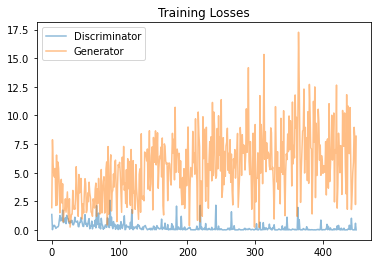

In [21]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

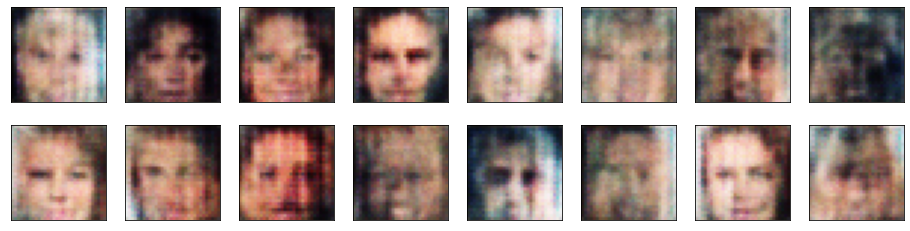

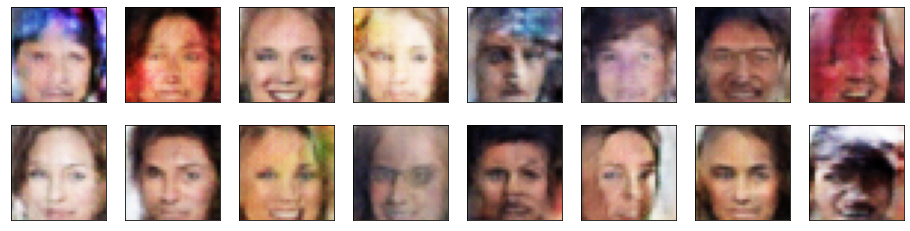

In [47]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

# load generated samples from disk
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
    
# view generated samples after the first epoch run
_ = view_samples(0, samples)

# view generated samples after the last epoch run
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples, and how might you improve this model?

**Answer:** I am quite surprised how well the DCGAN performed. The Generator definitely generated new images of faces that look realistic. You can even distinguish between men and women. I would not be able to tell that the two faces shown on the far bottom left corner were based from a random uniform distribution. That is how realistic they look. There are some obvious generation errors, such as the black spot on the far bottom right corner. This black spot may be related to training images that show faces with dark glasses. Generally, when you compare the first and last epoch runs, you can clearly see that the Generator improves throughout the training process as the image quality increases. Some faces show weird color artifacts, though.

In terms of further improvement, I would suggest to try adding a few more hidden convolutional layers for both Generator and Discriminator. Maybe that helps to generate even better images, but I wanted to keep a balance with training time. Already, I increased the number of dimensions in the convolutional layers as well as the latent vector size compared to the DCGAN Street View House Number exercise. I think this has helped, because the image quality has improved significantly here. In terms of better data pre-processing, I would also remove training images that show faces from the side. This is what I consider as noise, because these images do not fall into the portrait category. I would also take a closer look into the optimizer settings, because the Generator loss curve seems to be quite volatile.